In [ ]:
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmaps as gvcmaps
import dask
import geocat.viz.util as gvutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

## Historical & ERA5 vs. FLEXTRKR

In [2]:
obs_path = "/glade/work/malbright/storm_tracking/historical/observed/"
obs = xr.open_dataset(obs_path + "mcs_seasonal_mean_map_2014_2019.nc")
obs = obs["mcs_number"]
obs = obs.sel(season=["MAM", "JJA"])
flex = obs.sum(dim="season")

In [3]:
def add_time(ds):
    # Adds a length-1 time dimension to every file
    return ds.expand_dims(time=[0])


def load_files(files):
    ds = xr.open_mfdataset(
        files,
        combine="nested",
        concat_dim="time",
        preprocess=add_time,
        coords="minimal",
        data_vars="minimal",
        compat="override",
        parallel=True,
    ).unique_id_counts_climatology
    ds_mean = ds.mean("time", keep_attrs=True).load()
    return ds_mean.load()

In [ ]:
path = "/glade/derecho/scratch/malbright/nam_mcs_tracking"
era_us_files = sorted(
    glob.glob(f"{path}/era5/mcs_counts/era5_blobs_counts_US_*_MAMJJA.nc")
)
era_us = load_files(era_us_files)


cesm_us_files = sorted(
    glob.glob(f"{path}/historical/mcs_counts/historical_blobs_counts_US_*_MAMJJA.nc")
)
cesm_us = load_files(cesm_us_files)

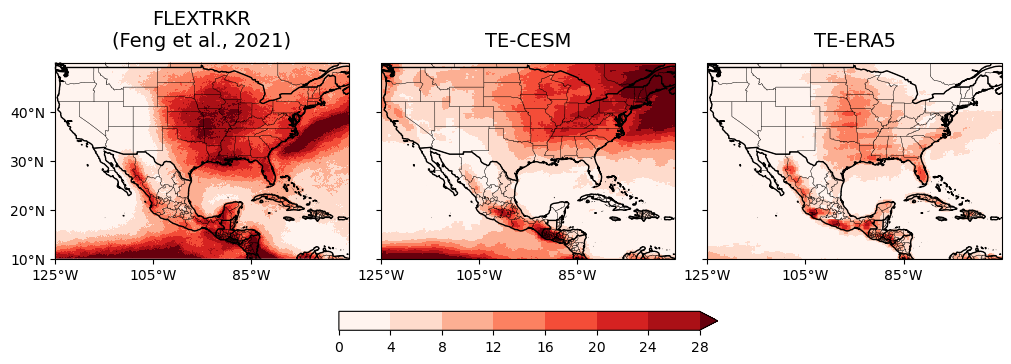

In [ ]:
# Specify projection for maps
proj = ccrs.PlateCarree()

# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=1)
# width_ratios=[0.75,0.75], wspace=0.25)

###############################
### TOP PANEL
###############################

# Create axis for FLEXTRKR MCS Counts
ax1 = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree())

# ERA5 TE
ax3 = fig.add_subplot(grid[0, 2], projection=ccrs.PlateCarree())

# CESM TE
ax5 = fig.add_subplot(grid[0, 1], projection=ccrs.PlateCarree())

for ax in [ax1, ax3, ax5]:
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            category="cultural",
            name="admin_1_states_provinces",
            scale="10m",
            facecolor="none",
            edgecolor="black",
            linewidth=0.2,
        ),
        zorder=3,
    )
    ax.add_feature(cfeature.COASTLINE, zorder=4)
    ax.add_feature(cfeature.BORDERS)

###############################
### FORMAT SUBPLOTS
###############################
# Format ticks and ticklabels for the map axes
for ax in [ax1, ax3, ax5]:
    gvutil.set_axes_limits_and_ticks(
        ax,
        xlim=(-125, -65),
        ylim=(10, 50),
        xticks=np.linspace(-125, -65, 20),
        yticks=np.linspace(10, 50, 10),
    )

# for ax in [ax2, ax4, ax6]:
#     gvutil.set_axes_limits_and_ticks(
#         ax,
#         xlim=(70, 135),
#         ylim=(20, 55),
#         xticks=np.linspace(70, 135, 20),
#         yticks=np.linspace(20, 55, 10),
#     )

ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())

# ax2.xaxis.set_tick_params(labelleft=False)
# ax2.yaxis.set_major_formatter(LatitudeFormatter())

ax3.xaxis.set_major_formatter(LongitudeFormatter())
ax3.yaxis.set_tick_params(labelleft=False)

# ax4.xaxis.set_tick_params(labelleft=False)
# ax4.yaxis.set_major_formatter(LatitudeFormatter())

ax5.xaxis.set_major_formatter(LongitudeFormatter())
ax5.yaxis.set_tick_params(labelleft=False)

# ax6.xaxis.set_major_formatter(LongitudeFormatter())
# ax6.yaxis.set_major_formatter(LatitudeFormatter())

###################################################
### FLEXTRKR PLOTS
###################################################

############# FLEXTRKR US

newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 30, 4)

kwargs_us = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),
    yticks=np.arange(10, 50, 10),
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)

fillplot1 = flex.plot(ax=ax1, cmap=newcmp, **kwargs_us)

gvutil.set_titles_and_labels(
    ax1, xlabel="", ylabel="", labelfontsize=12
)
ax1.set_title("FLEXTRKR\n(Feng et al., 2021)", fontsize=14, loc="center", y=1.04)

###################################################
### ERA5 PLOTS
###################################################

############# TE US

fillplot3 = era_us.plot(ax=ax3, cmap=newcmp, **kwargs_us)

gvutil.set_titles_and_labels(ax3, xlabel="", ylabel="", labelfontsize=12)
ax3.set_title("TE-ERA5", fontsize=14, loc="center", y=1.04)

###################################################
### CESM PLOTS
###################################################

############# TE US

fillplot5 = cesm_us.plot(ax=ax5, cmap=newcmp, **kwargs_us)

gvutil.set_titles_and_labels(ax5, xlabel="", ylabel="", labelfontsize=12)
ax5.set_title("TE-CESM", fontsize=14, loc="center", y=1.04)

fig.colorbar(
    fillplot1,
    # ax=[ax1, ax2, ax3, ax4, ax5, ax6],
    ax=[ax1, ax3,  ax5],
    orientation="horizontal",
    ticks=levels,
    label="",
    shrink=0.4,
    pad=0.05,
)

# plt.show()
figname = 'figures/final_supplemental_mcs_validation.png'
plt.savefig(figname, dpi=150, facecolor='w', bbox_inches='tight')

# Old:

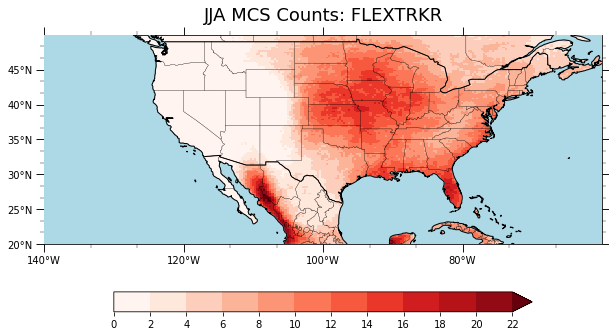

In [22]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-140, -60),
    ylim=(20, 50),
    xticks=np.linspace(-140, -60, 20),
    yticks=np.linspace(20, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 24, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-140, -60, 20),  # nice x ticks
    yticks=np.arange(20, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = obs_jja["_linint2-9cb1f160ddcbbe972beb7ad1428e16b8"].plot(
    ax=ax, cmap=newcmp, **kwargs
)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="JJA MCS Counts: FLEXTRKR",
    # lefttitle='Minsize: 64; Mintime: 4; Overlap: 50%-90%',
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()
# plt.savefig('mcs_blobs.9.4_10_90.pdf', bbox_inches='tight')

## Mapping Pliocene SW NA

In [3]:
ds = xr.open_dataset(
    "/glade/scratch/malbright/mcs_tracking/preindustrial/mcs_counts/mcs_blobs_mintime4_minsize6_overlap10-90_jj.nc"
)

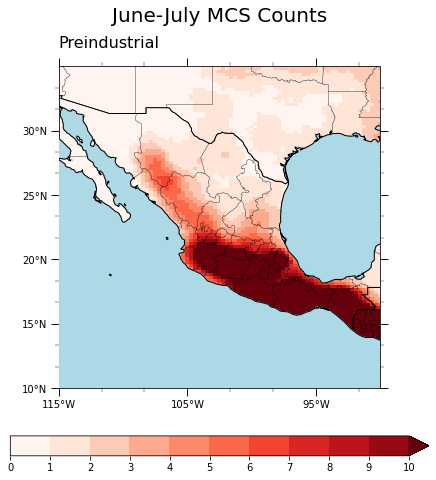

In [4]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 11, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July MCS Counts",
    lefttitle="Preindustrial",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("pi_mcs_counts_mintime4_minsize6_overlap10-90_jj.nc.pdf")

In [5]:
ds_plio = xr.open_dataset(
    "/glade/scratch/malbright/mcs_tracking/pliocene/mcs_counts/mcs_blobs_mintime4_minsize6_overlap10-90_jj.nc"
)

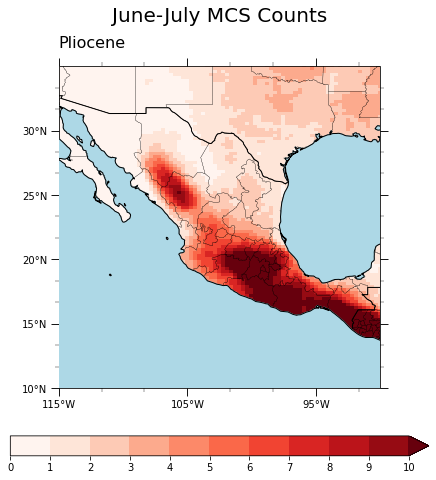

In [6]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 11, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds_plio.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July MCS Counts",
    lefttitle="Pliocene",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("plio_mcs_counts_mintime4_minsize6_overlap10-90_jj.nc.pdf")

In [7]:
diff = ds_plio - ds

In [ ]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.precip_diff_12lev

levels = np.arange(-4, 4.5, 0.5)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = diff.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot,
    orientation="vertical",
    ticks=np.arange(-4, 4.5, 1),
    label="",
    shrink=0.75,
    pad=0.11,
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July MCS Counts",
    lefttitle="Pliocene minus Preindustrial",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("diff_jj_mcs_counts_mintime4_minsize6_overlap10-90_jj.pdf")

## Mapping Preindustrial SW NA

In [6]:
ds_pi = xr.open_dataset(
    "/glade/scratch/malbright/mcs_tracking/pliocene/mcs_rate/mcs_avg_precip_jj_plio.nc"
)

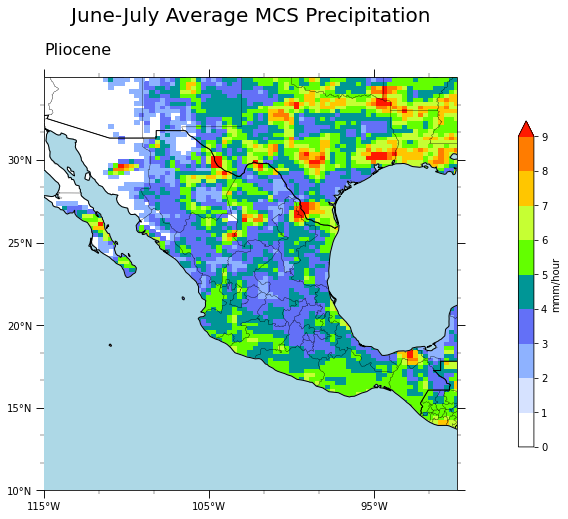

In [8]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.precip3_16lev

levels = np.arange(0, 10, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds_pi.__xarray_dataarray_variable__.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot,
    orientation="vertical",
    ticks=levels,
    label="mmm/hour",
    shrink=0.75,
    pad=0.11,
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July Average MCS Precipitation",
    lefttitle="Pliocene",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()
# plt.savefig('pi_jj_mcs_counts.pdf')

### Mapping ERA5 SW NA

In [8]:
ds_era5 = xr.open_dataset(
    "/glade/scratch/malbright/mcs_tracking/era5/mcs_counts/mcs_jj_era5_global.nc"
)

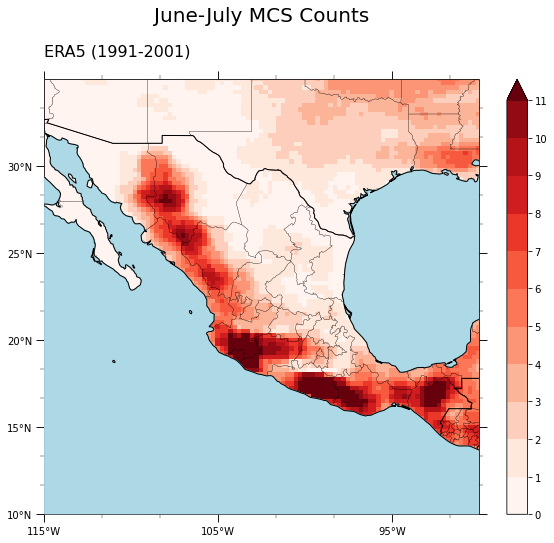

In [10]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 12, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds_era5.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(fillplot, orientation="vertical", ticks=levels, label="")  # ,
# shrink=0.75,
# pad=0.11)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July MCS Counts",
    lefttitle="ERA5 (1991-2001)",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("era5_jj_mcs_counts.pdf")

## Mapping SW NA difference

In [7]:
diff = ds_plio - ds_pi

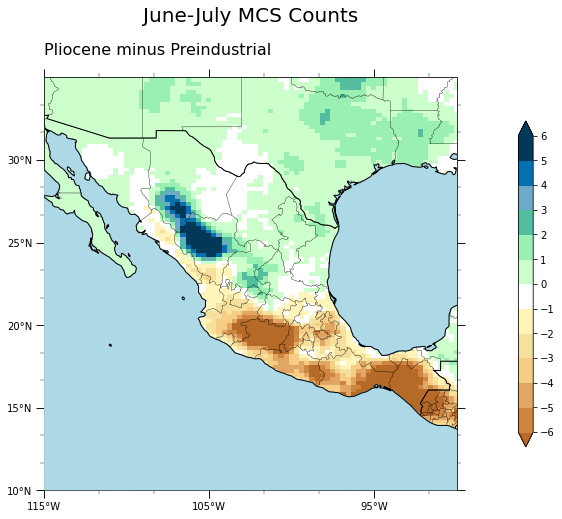

In [9]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.precip_diff_12lev

levels = np.arange(-6, 7, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = diff.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="vertical", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July MCS Counts",
    lefttitle="Pliocene minus Preindustrial",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("diff_jj_mcs_counts.pdf")

## Mapping best parameters after rmse

In [9]:
ds = xr.open_dataset(
    "/glade/scratch/malbright/historical/dask_computed/mcs_half_1_2_20.nc"
)  # .sel(lon=slice(235, 295))

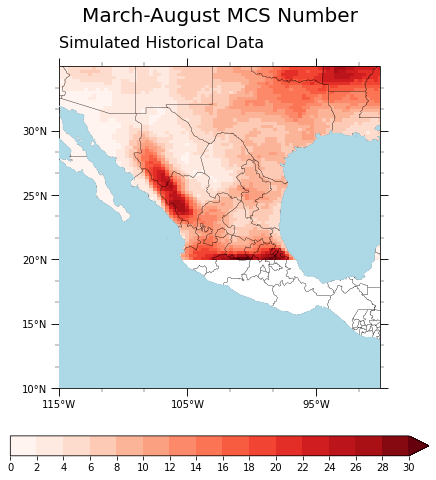

In [10]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-115, -90, 10),
    yticks=np.linspace(10, 35, 5),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 32, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-115, -90, 10),  # nice x ticks
    yticks=np.arange(10, 35, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Number",
    lefttitle="Simulated Historical Data",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()

In [3]:
ds2 = xr.open_dataset(
    "/glade/scratch/malbright/mcs_tracking/era5/mcs_counts/mcs_blobs2.2_reg.nc"
)

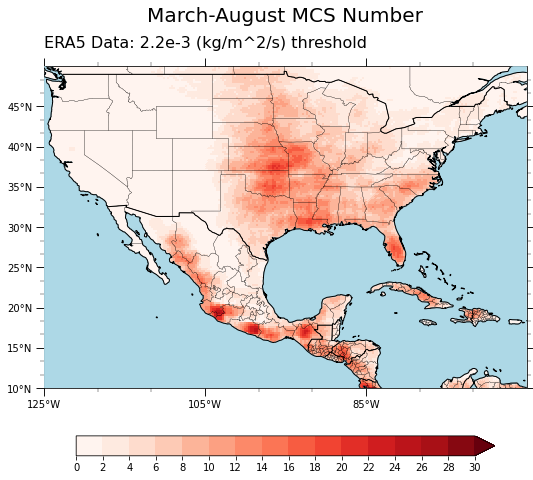

In [4]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-125, -65),
    ylim=(10, 50),
    xticks=np.linspace(-125, -65, 20),
    yticks=np.linspace(10, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 32, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),  # nice x ticks
    yticks=np.arange(10, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds2.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Number",
    lefttitle="ERA5 Data: 2.2e-3 (kg/m^2/s) threshold",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()

In [3]:
obs = (
    xr.open_dataset(
        "/glade/u/home/malbright/work/storm_tracking/historical/observed/mcs_season_number.nc"
    )
    .sel(lat=slice(10, 50))
    .sel(lon=slice(-125, -65))
)
obs = obs.sel(season=["JJA", "MAM"])
obs = obs.sum(dim="season")

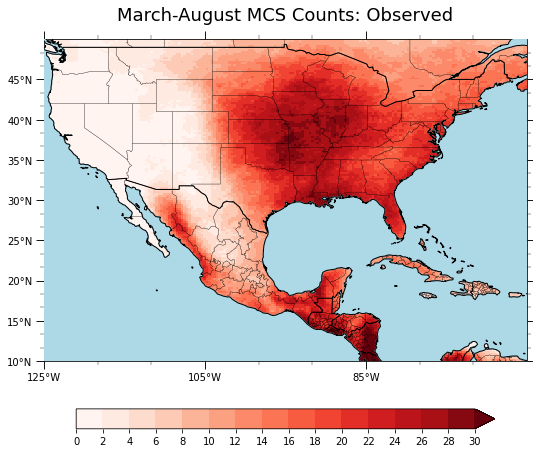

In [14]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-125, -65),
    ylim=(10, 50),
    xticks=np.linspace(-125, -65, 20),
    yticks=np.linspace(10, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 32, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),  # nice x ticks
    yticks=np.arange(10, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = obs["_linint2-9cb1f160ddcbbe972beb7ad1428e16b8"].plot(
    ax=ax, cmap=newcmp, **kwargs
)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Counts: Observed",
    # lefttitle='Observed Data',
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("observed_mcs_mamjja.pdf", bbox_inches="tight")

In [24]:
ds = xr.open_dataset(
    "/glade/scratch/malbright/historical/mcs_counts/mcs_blobs_time4_size6_overlap90_jj.nc"
)

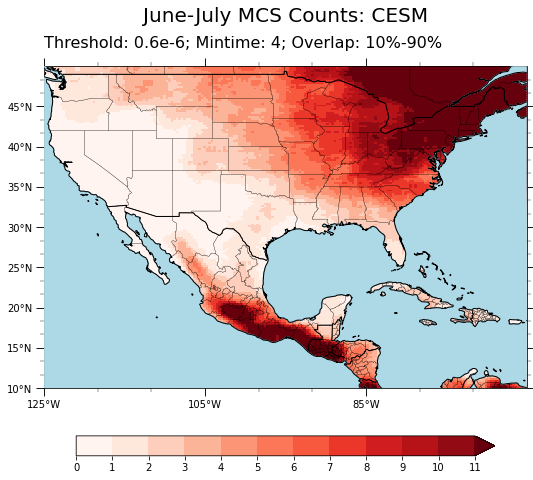

In [25]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-125, -65),
    ylim=(10, 50),
    xticks=np.linspace(-125, -65, 20),
    yticks=np.linspace(10, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

# levels = np.arange(0, 32, 2)
levels = np.arange(0, 12, 1)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),  # nice x ticks
    yticks=np.arange(10, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="June-July MCS Counts: CESM",
    lefttitle="Threshold: 0.6e-6; Mintime: 4; Overlap: 10%-90%",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("mcs_blobs_time4_size6_overlap90_jj.pdf", bbox_inches="tight")

In [30]:
ds = xr.open_dataset(
    "/glade/scratch/malbright/historical/mcs_counts/threshold.6/mcs_blobs.6.2_10_60.nc"
)

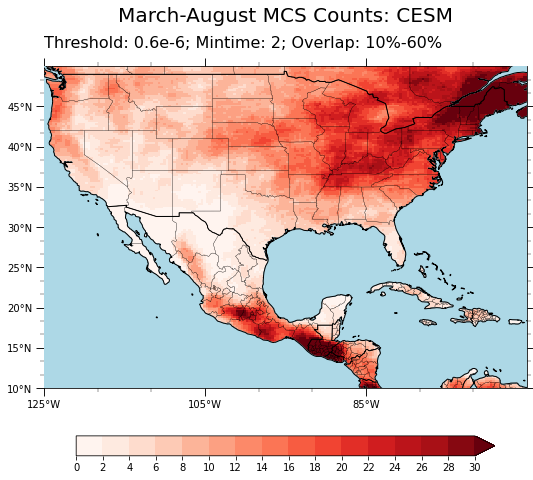

In [31]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-125, -65),
    ylim=(10, 50),
    xticks=np.linspace(-125, -65, 20),
    yticks=np.linspace(10, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 32, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),  # nice x ticks
    yticks=np.arange(10, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Counts: CESM",
    lefttitle="Threshold: 0.6e-6; Mintime: 2; Overlap: 10%-60%",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("mcs_blobs.6.2_10_60.pdf", bbox_inches="tight")

In [28]:
ds = xr.open_dataset(
    "/glade/scratch/malbright/historical/mcs_counts/threshold.9/mcs_blobs.9.4_10_90.nc"
)

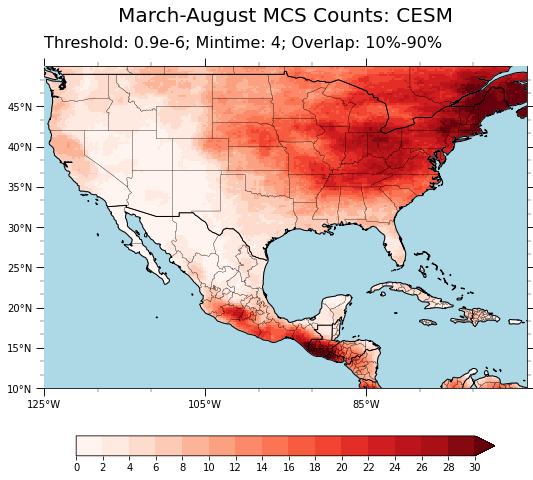

In [29]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)
ax.add_feature(cfeature.COASTLINE, zorder=4)
ax.add_feature(cfeature.BORDERS)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-125, -65),
    ylim=(10, 50),
    xticks=np.linspace(-125, -65, 20),
    yticks=np.linspace(10, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 32, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),  # nice x ticks
    yticks=np.arange(10, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Counts: CESM",
    lefttitle="Threshold: 0.9e-6; Mintime: 4; Overlap: 10%-90%",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

# plt.show()
plt.savefig("mcs_blobs.9.4_10_90.pdf", bbox_inches="tight")

### Mapping MAMJJA Pliocene

In [4]:
global_plio = xr.open_dataset(
    "/glade/scratch/malbright/mcs_tracking/pliocene/mcs_counts/mcs_mamjja_plio_global.nc"
)  # .sel(lat=slice(20, 50)).sel(lon=slice(-125, -65))

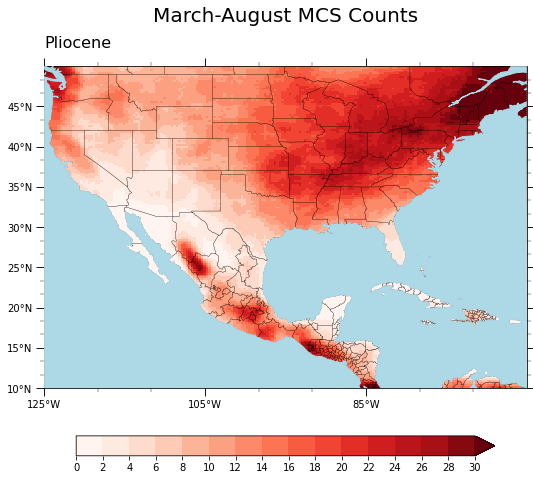

In [6]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-125, -65),
    ylim=(10, 50),
    xticks=np.linspace(-125, -65, 20),
    yticks=np.linspace(10, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 32, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-125, -65, 20),  # nice x ticks
    yticks=np.arange(10, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = global_plio.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Counts",
    lefttitle="Pliocene",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()

### Mapping as panel:

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geocat.datafiles as gdf
import geocat.viz.util as gvutil
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
from geocat.viz import cmaps as gvcmaps

In [41]:
def add_axes(fig, grid_space, title):
    ax = fig.add_subplot(grid_space, projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            category="cultural",
            name="admin_1_states_provinces",
            scale="10m",
            facecolor="none",
            edgecolor="black",
            linewidth=0.2,
        ),
        zorder=3,
    )
    ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

    # Use geocat.viz.util convenience function to set axes limits & tick values
    gvutil.set_axes_limits_and_ticks(
        ax,
        xlim=(-125, -65),
        ylim=(10, 50),
        xticks=np.linspace(-125, -65, 20),
        yticks=np.linspace(10, 50, 10),
    )

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax, labelsize=10)

    # Make sure that tick marks are only on the left and bottom sides of subplot
    ax.tick_params("both", which="both", top=False, right=False)

    # Use geocat.viz.util convenience function to make lat, lon tick labels
    gvutil.add_lat_lon_ticklabels(ax)

    ax.set_title(title, fontsize=10, y=1.04)

    return ax

In [43]:
def create_fig(grid, fig, title):
    # Add the axes
    ax1 = add_axes(fig, grid[0, 0], "mcs_half_1_2_20.nc")
    ax2 = add_axes(fig, grid[0, 1], "mcs_half_2_2_20.nc")
    ax3 = add_axes(fig, grid[1, 0], "mcs_half_4_2_20.nc")
    ax4 = add_axes(fig, grid[1, 1], "mcs_half_6_2_20.nc")

    # newcmp = gvcmaps.MPL_Reds

    levels = np.arange(0, 32, 2)

    # kwargs = dict(
    #    levels=levels,
    #    xticks=np.arange(-125, -65, 20),  # nice x ticks
    #    yticks=np.arange(10, 50, 5),  # nice y ticks
    #    add_colorbar=False,  # allow for colorbar specification later
    #    transform=ccrs.PlateCarree(),  # ds projection
    # )
    contourf_kw = dict(
        transform=ccrs.PlateCarree(),
        levels=levels,
        cmap=gvcmaps.MPL_Reds,
        add_colorbar=False,
        add_labels=False,
        vmin=-5,
        vmax=5,
        extend="both",
        zorder=1,
    )

    # Plot the filled contours
    contour1 = data1.variable.plot(ax=ax, **contourf_kw)
    contour2 = data2.variable.plot(ax=ax, **contourf_kw)
    contour3 = data3.variable.plot(ax=ax, **contourf_kw)
    contour4 = data4.variable.plot(ax=ax, **contourf_kw)
    # obs.mcs.plot(ax=ax, cmap=newcmp, **kwargs)
    # ds2.variable.plot(ax=ax, cmap=newcmp, **kwargs)

    # Add colorbar for all four plots
    fig.colorbar(
        contour4,
        ax=[ax1, ax2, ax3, ax4],
        ticks=levels,
        drawedges=True,
        orientation="horizontal",
        shrink=0.5,
        pad=0.075,
        extendfrac="auto",
        extendrect=True,
    )

    # Add figure title
    fig.suptitle(title, fontsize=18, y=0.9)

    plt.show()

In [39]:
# Open a netCDF data file using xarray default engine and load the data into xarrays

data1 = xr.open_dataset(
    "/glade/scratch/malbright/historical/dask_computed/north_america/mcs_half_1_2_20.nc"
)

data2 = xr.open_dataset(
    "/glade/scratch/malbright/historical/dask_computed/north_america/mcs_half_2_2_20.nc"
)

data3 = xr.open_dataset(
    "/glade/scratch/malbright/historical/dask_computed/north_america/mcs_half_4_2_20.nc"
)

data4 = xr.open_dataset(
    "/glade/scratch/malbright/historical/dask_computed/north_america/mcs_half_6_2_20.nc"
)

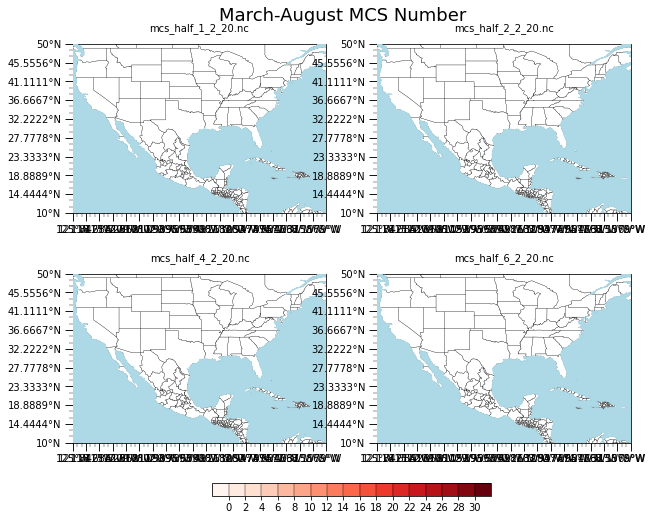

In [44]:
fig = plt.figure(figsize=(10, 10))

# Create gridspec to hold four subplots
grid = fig.add_gridspec(ncols=2, nrows=2)

title = "March-August MCS Number"

# Create the figure with the given title and gridspec
create_fig(grid, fig, title)

### China

In [8]:
ds = xr.open_dataset(
    "/glade/scratch/malbright/historical/dask_computed/original_threshold/china/mcs_6_2_10.nc"
)

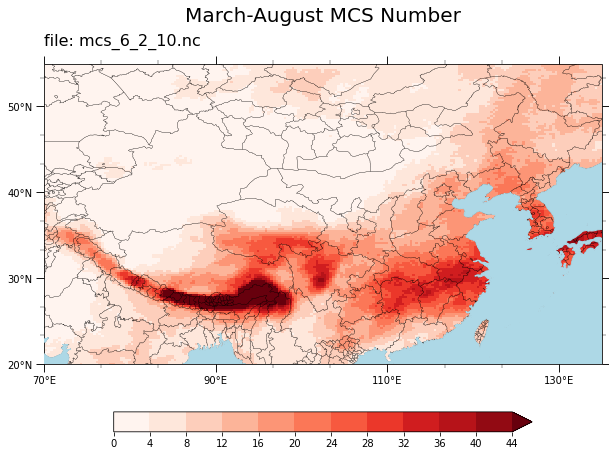

In [9]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(70, 135),
    ylim=(20, 55),
    xticks=np.linspace(70, 135, 20),
    yticks=np.linspace(20, 55, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 48, 4)

kwargs = dict(
    levels=levels,
    xticks=np.arange(70, 135, 20),  # nice x ticks
    yticks=np.arange(20, 55, 10),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds.variable.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Number",
    lefttitle="file: mcs_6_2_10.nc",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()

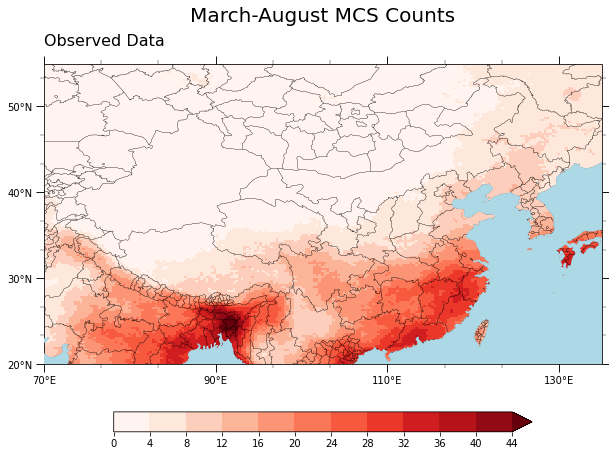

In [7]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(70, 135),
    ylim=(20, 55),
    xticks=np.linspace(70, 135, 20),
    yticks=np.linspace(20, 55, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make lat, lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_Reds

levels = np.arange(0, 48, 4)

kwargs = dict(
    levels=levels,
    xticks=np.arange(70, 135, 20),  # nice x ticks
    yticks=np.arange(20, 55, 10),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = obs.mcs.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

gvutil.set_titles_and_labels(
    ax,
    maintitle="March-August MCS Counts",
    lefttitle="Observed Data",
    lefttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()

In [2]:
ds = (
    xr.open_mfdataset(
        "/glade/u/home/malbright/scratch/historical/blobs/blobs*.nc", parallel=True
    )
    .sel(lat=slice(25, 50))
    .sel(lon=slice(250, 295))
)

In [2]:
ds1 = (
    xr.open_dataset("/glade/u/home/malbright/scratch/historical/blobs/blobs1.nc")
    .sel(lat=slice(25, 50))
    .sel(lon=slice(250, 295))
)

In [36]:
ds1 = (
    xr.open_dataset("/glade/u/home/malbright/scratch/historical/blobs/blobs1.nc")
    .sel(lat=slice(20, 21))
    .sel(lon=slice(250, 251))
)

In [3]:
ds1

<xarray.Dataset>
Dimensions:    (lat: 4, lon: 4, time: 35040)
Coordinates:
  * time       (time) object 1991-01-01 00:37:00 ... 1994-12-31 23:38:00
  * lat        (lat) float64 20.07 20.3 20.53 20.77
  * lon        (lon) float64 250.0 250.3 250.6 250.9
Data variables:
    MCS_PRECT  (time, lat, lon) int32 ...

In [3]:
# ds.sel('time.month' = [3, 4, 5, 6, 7, 8])
# ds.sel(time = (ds['time.month'] = [3, 4, 5, 6, 7, 8]))


def is_month(month):
    return (month >= 3) & (month <= 8)


ds_month = ds.sel(time=is_month(ds["time.month"]))

NameError: name 'ds' is not defined

In [3]:
def is_month(month):
    return (month >= 3) & (month <= 8)


ds1_month = ds1.sel(time=is_month(ds1["time.month"]))

In [59]:
print(ds1_month)

<xarray.Dataset>
Dimensions:    (lat: 106, lon: 145, time: 17664)
Coordinates:
  * time       (time) object 1991-03-01 00:37:00 ... 1994-08-31 23:38:00
  * lat        (lat) float64 25.23 25.46 25.7 25.93 ... 49.17 49.4 49.63 49.87
  * lon        (lon) float64 250.0 250.3 250.6 250.9 ... 294.1 294.4 294.7 295.0
Data variables:
    MCS_PRECT  (time, lat, lon) int32 ...


In [38]:
# create data
data = np.zeros((len(ds1_month.lat), len(ds1_month.lon)))

# create coordinates
lat = ds1_month.lat
lon = ds1_month.lon
row_meshgrid, col_meshgrid = np.meshgrid(lat, lon, indexing="ij")

new_ds1 = xr.Dataset(
    data_vars=dict(variable=(["lat", "lon"], data)),
    coords=dict(row=(["lat", "lon"], row_meshgrid), col=(["lat", "lon"], col_meshgrid)),
)

In [5]:
# create dask client and cluster:
# Import dask
import dask

# Import a client
from dask.distributed import Client

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Setup your PBSCluster
cluster = PBSCluster(
    # cores=1, # The number of cores you want
    # memory='10GB', # Amount of memory
    # processes=1, # How many processes
    queue="casper",  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory="/glade/u/home/malbright",  # Use your local directory
    resource_spec="select=1:ncpus=10:mem=100GB",  # Specify resources
    project="UCNN0024",  # Input your project ID here
    walltime="02:00:00",  # Amount of wall time
    interface="ib0",  # Interface to use
)

# Scale up
# cluster.scale(20)
cluster.adapt(minimum=10, maximum=200)

# Change your url to the dask dashboard so you can see it
dask.config.set(
    {
        "distributed.dashboard.link": "https://jupyterhub.hpc.ucar.edu/stable/user/malbright/proxy/{port}/status"
    }
)

# Setup your client
client = Client(cluster)
client

Client Scheduler: tcp://10.12.206.53:40760 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/malbright/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
for i in range(len(ex_prect.lat)):
    for j in range(len(ex_prect.lon)):
        new_ds[i, j] = np.count_nonzero(np.unique(ex_prect[:, i, j]))

In [44]:
def num_un(ds_in, ds_out, i, j):
    ds_out.variable[i, j] = np.count_nonzero(np.unique(ds_in.MCS_PRECT[:, i, j]))
    return ds_out

In [45]:
delayed_num = dask.delayed(num_un)

In [46]:
for i in range(len(ds1_month.lat)):
    for j in range(len(ds1_month.lon)):
        new_ds1 = delayed_num(ds1_month, new_ds1, i, j)

In [47]:
computed_ds1 = dask.compute(new_ds1)

In [53]:
computed_ds1

(<xarray.Dataset>
 Dimensions:   (lat: 4, lon: 4)
 Coordinates:
     row       (lat, lon) float64 20.07 20.07 20.07 20.07 ... 20.77 20.77 20.77
     col       (lat, lon) float64 250.0 250.3 250.6 250.9 ... 250.3 250.6 250.9
 Dimensions without coordinates: lat, lon
 Data variables:
     variable  (lat, lon) float64 7.0 7.0 6.0 6.0 8.0 7.0 ... 7.0 8.0 7.0 7.0 7.0,)

In [54]:
computed_ds1.to_netcdf(
    "/glade/u/home/malbright/scratch/historical/dask/computed/ds1.nc"
)

AttributeError: 'tuple' object has no attribute 'to_netcdf'

In [40]:
new_ds1.variable[0, 0] = np.count_nonzero(np.unique(ds1_month.MCS_PRECT[:, 0, 0]))

In [9]:
client.close()
cluster.close()

Task exception was never retrieved
future: <Task finished coro=<_wrap_awaitable() done, defined at /glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/lib/python3.7/asyncio/tasks.py:623> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 191\nCommand:\nqsub /glade/scratch/malbright/tmp19ta2jh8.sh\nstdout:\n\nstderr:\nqsub: Job rejected by all possible destinations\n\n')>
Traceback (most recent call last):
  File "/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/lib/python3.7/asyncio/tasks.py", line 630, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/distributed/deploy/spec.py", line 71, in _
    await self.start()
  File "/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask_jobqueue/core.py", line 324, in start
    out = await self._submit_job(fn)
  File "/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask_job

KeyboardInterrupt: 

### here:

In [ ]:
new_dask = ds1_month.to_dask_dataframe()

In [7]:
new_dask.nunique()

AttributeError: 'DataFrame' object has no attribute 'Series'

In [65]:
new = ds1_month.to_array()
new_reshaped = new.values.reshape(17664, 15370)

In [68]:
new_reshaped

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [61]:
def pan(ds):
    return pd.DataFrame(ds)

In [62]:
delayed_pan = dask.delayed(pan)

In [66]:
df = delayed_pan(new_reshaped)

In [13]:
# num_un(ds1_na, new_ds1, 1, 1)
new_ds1[0, 0] = np.count_nonzero(np.unique(ds1_month.MCS_PRECT[:, 0, 0]))

In [14]:
print(new_ds1)

<xarray.DataArray (lat: 106, lon: 145)>
array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 49.17 49.4 49.63 49.87
  * lon      (lon) float64 250.0 250.3 250.6 250.9 ... 294.1 294.4 294.7 295.0


10

### Yearly total

In [42]:
print(ds)

<xarray.Dataset>
Dimensions:    (lat: 106, lon: 129, time: 113880)
Coordinates:
  * time       (time) object 1991-01-01 00:37:00 ... 2003-12-31 23:38:00
  * lat        (lat) float64 25.23 25.46 25.7 25.93 ... 49.17 49.4 49.63 49.87
  * lon        (lon) float64 250.0 250.3 250.6 250.9 ... 289.1 289.4 289.7 290.0
Data variables:
    MCS_PRECT  (time, lat, lon) int32 dask.array<chunksize=(35040, 106, 129), meta=np.ndarray>


In [69]:
ds2 = xr.where(ds > 0, 1, 0)
ds_sum = ds2.groupby("time.year").sum()

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[inde

In [70]:
ds_mean = ds_sum.mean(dim="year")

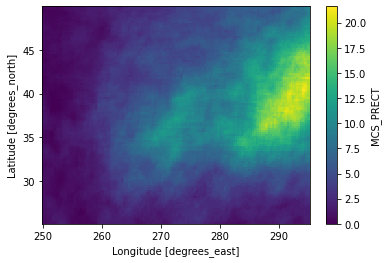

In [71]:
ds_mean.MCS_PRECT.plot()

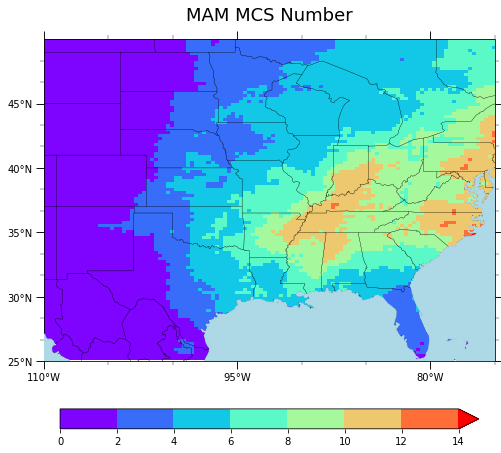

In [103]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
# zorder=5))
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-110, -75),
    ylim=(25, 50),
    xticks=np.linspace(-110, -75, 20),
    yticks=np.linspace(25, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make latitude, longitude tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_rainbow

levels = np.arange(0, 15, 2)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-110, -75, 15),  # nice x ticks
    yticks=np.arange(25, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = ds_mean.MCS_PRECT.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

# m_mean.binary_tag.plot(ax=ax, zorder = 1)

gvutil.set_titles_and_labels(ax, maintitle="MAM MCS Number", xlabel="", ylabel="")

plt.show()

### March-August total

In [3]:
b = xr.where(ds > 0, 1, 0)

In [4]:
b_month = b.groupby("time.month").sum()
mamjja = b_month.sel(month=[3, 4, 5, 6, 7, 8])
blobs = mamjja.sum(dim="month")

In [5]:
blobs = blobs / 13

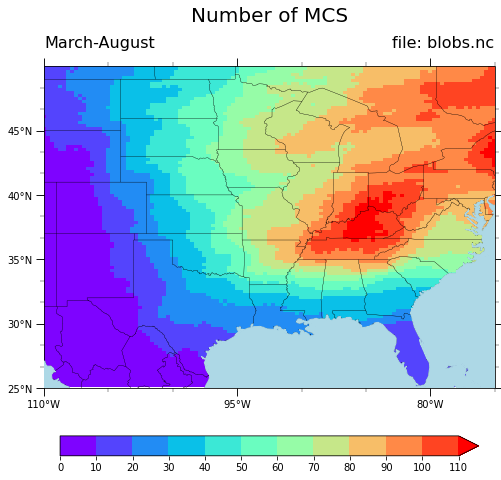

In [8]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5, alpha=0.6, zorder=2)
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale="10m",
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
    ),
    zorder=3,
)
# zorder=5))
ax.add_feature(cfeature.OCEAN, color="lightblue", zorder=4)

# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(
    ax,
    xlim=(-110, -75),
    ylim=(25, 50),
    xticks=np.linspace(-110, -75, 20),
    yticks=np.linspace(25, 50, 10),
)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, labelsize=10)

# Use geocat.viz.util convenience function to make latitude, longitude tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Import color map
newcmp = gvcmaps.MPL_rainbow

levels = np.arange(0, 120, 10)

kwargs = dict(
    levels=levels,
    xticks=np.arange(-110, -75, 15),  # nice x ticks
    yticks=np.arange(25, 50, 5),  # nice y ticks
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
)

fillplot = blobs.MCS_PRECT.plot(ax=ax, cmap=newcmp, **kwargs)

fig.colorbar(
    fillplot, orientation="horizontal", ticks=levels, label="", shrink=0.75, pad=0.11
)

# m_mean.binary_tag.plot(ax=ax, zorder = 1)

gvutil.set_titles_and_labels(
    ax,
    maintitle="Number of MCS",
    lefttitle="March-August",
    lefttitlefontsize=16,
    righttitle="file: blobs.nc",
    righttitlefontsize=16,
    xlabel="",
    ylabel="",
)

plt.show()

### Below are examples/work space

In [15]:
# create dummy dataframe
times = pd.date_range(start="2000-01-01", freq="1H", periods=6)

# create dataset
ex_ds = xr.Dataset(
    {
        "SWdown": xr.DataArray(
            data=np.random.random(6),  # enter data here
            dims=["time"],
            coords={"time": times},
            attrs={"_FillValue": -999.9, "units": "W/m2"},
        ),
        "LWdown": xr.DataArray(
            data=np.random.random(6),  # enter data here
            dims=["time"],
            coords={"time": times},
            attrs={"_FillValue": -999.9, "units": "W/m2"},
        ),
    },
    attrs={"example_attr": "this is a global attribute"},
)

In [16]:
ex_ds

<xarray.Dataset>
Dimensions:  (time: 6)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T05:00:00
Data variables:
    SWdown   (time) float64 0.2924 0.1174 0.4922 0.6299 0.2514 0.8092
    LWdown   (time) float64 0.6186 0.09403 0.2248 0.8375 0.6304 0.6529
Attributes:
    example_attr:  this is a global attribute

In [17]:
print(ex_ds)

<xarray.Dataset>
Dimensions:  (time: 6)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T05:00:00
Data variables:
    SWdown   (time) float64 0.2924 0.1174 0.4922 0.6299 0.2514 0.8092
    LWdown   (time) float64 0.6186 0.09403 0.2248 0.8375 0.6304 0.6529
Attributes:
    example_attr:  this is a global attribute


In [18]:
ex_ds2 = ex_ds.where(ex_ds > 0.5)

In [19]:
print(ex_ds2)

<xarray.Dataset>
Dimensions:  (time: 6)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T05:00:00
Data variables:
    SWdown   (time) float64 nan nan nan 0.6299 nan 0.8092
    LWdown   (time) float64 0.6186 nan nan 0.8375 0.6304 0.6529
Attributes:
    example_attr:  this is a global attribute


In [32]:
np.count_nonzero(np.unique(ex_ds2.SWdown))

6

In [3]:
dval = np.random.randint(5, size=[3, 4, 4])
x = [0, 1, 2, 3]
y = [0, 1, 2, 3]
time = ["2017-10-13", "2017-10-12", "2017-10-11"]

a = xr.DataArray(dval, coords=[time, x, y], dims=["time", "x", "y"])

In [4]:
a

<xarray.DataArray (time: 3, x: 4, y: 4)>
array([[[0, 0, 3, 1],
        [1, 4, 4, 2],
        [3, 2, 0, 3],
        [1, 2, 0, 2]],

       [[1, 4, 0, 1],
        [1, 1, 4, 3],
        [0, 4, 4, 3],
        [0, 4, 3, 0]],

       [[0, 0, 4, 1],
        [1, 0, 2, 2],
        [0, 2, 3, 2],
        [3, 3, 2, 1]]])
Coordinates:
  * time     (time) <U10 '2017-10-13' '2017-10-12' '2017-10-11'
  * x        (x) int64 0 1 2 3
  * y        (y) int64 0 1 2 3

In [113]:
dval = np.random.randint(5, size=[len(ds.lat), len(ds.lon)])
lat = ds.lat
lon = ds.lon

a = xr.DataArray(dval, coords=[lat, lon], dims=["lat", "lon"])

In [114]:
a

<xarray.DataArray (lat: 106, lon: 145)>
array([[0, 4, 0, ..., 1, 0, 3],
       [1, 4, 0, ..., 2, 4, 0],
       [1, 4, 0, ..., 4, 1, 0],
       ...,
       [3, 0, 1, ..., 4, 1, 3],
       [1, 2, 4, ..., 3, 3, 2],
       [3, 4, 3, ..., 1, 4, 0]])
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 49.17 49.4 49.63 49.87
  * lon      (lon) float64 250.0 250.3 250.6 250.9 ... 294.1 294.4 294.7 295.0

In [8]:
a2 = a.where(a == 0, float("NaN"))

In [13]:
a2 = a.where(a > 0)

In [14]:
a2

<xarray.DataArray (time: 3, x: 4, y: 4)>
array([[[nan, nan,  3.,  1.],
        [ 1.,  4.,  4.,  2.],
        [ 3.,  2., nan,  3.],
        [ 1.,  2., nan,  2.]],

       [[ 1.,  4., nan,  1.],
        [ 1.,  1.,  4.,  3.],
        [nan,  4.,  4.,  3.],
        [nan,  4.,  3., nan]],

       [[nan, nan,  4.,  1.],
        [ 1., nan,  2.,  2.],
        [nan,  2.,  3.,  2.],
        [ 3.,  3.,  2.,  1.]]])
Coordinates:
  * time     (time) <U10 '2017-10-13' '2017-10-12' '2017-10-11'
  * x        (x) int64 0 1 2 3
  * y        (y) int64 0 1 2 3

In [30]:
a2.x.mean()

<xarray.DataArray 'x' ()>
array(1.5)

In [29]:
np.count_nonzero(np.unique(a))

4

In [30]:
np.unique(a)

array([0, 1, 2, 3, 4])

### practice with example netcdf dataset

In [36]:
# example netcdf dataset:
ex_netcdf = xr.open_dataset(
    "/glade/u/home/malbright/scratch/modern_day/ECMWF_ERA-40_subset.nc"
)

In [11]:
ex_netcdf

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, time: 62)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2002-07-01T12:00:00 ... 2002-07-31T18:00:00
Data variables:
    tcw        (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    p10u       (time, latitude, longitude) float32 ...
    p10v       (time, latitude, longitude) float32 ...
    p2t        (time, latitude, longitude) float32 ...
    p2d        (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    mcc        (time, latitude, longitude) float32 ...
    hcc        (time, latitude, longitude) float32 ...
    tco3       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      2004-09-15 17:04:29 GMT by mars2netcdf-0.92

In [37]:
tcw = ex_netcdf.tcw

In [38]:
tcw

<xarray.DataArray 'tcw' (time: 62, latitude: 73, longitude: 144)>
[651744 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2002-07-01T12:00:00 ... 2002-07-31T18:00:00
Attributes:
    units:      kg m**-2
    long_name:  Total column water

For reference: \
def num_un(ds_in, ds_out, i, j): \
    ds_out[i,j] = np.count_nonzero(np.unique(ds_in[:,i,j])) \
    return ds_out 

num_unique = np.vectorize(num_un)

In [12]:
# ds_in is going to be tcw
# ds_out is going to be the created dataset:
dval = np.random.randint(5, size=[len(tcw.latitude), len(tcw.longitude)])
lat = tcw.latitude
lon = tcw.longitude

new_tcw = xr.DataArray(dval, coords=[lat, lon], dims=["lat", "lon"])

In [33]:
new_tcw

<xarray.DataArray (lat: 73, lon: 144)>
array([[61, 61,  2, ...,  4,  0,  0],
       [ 0, 62,  4, ...,  3,  3,  1],
       [ 2,  0,  4, ...,  4,  1,  3],
       ...,
       [ 0,  4,  4, ...,  4,  0,  2],
       [ 1,  3,  2, ...,  4,  2,  1],
       [ 2,  4,  4, ...,  3,  3,  4]])
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [20]:
lat = list(range(len(lat)))

In [31]:
newest_tcw = num_un(tcw, new_tcw, 0, 1)

In [32]:
newest_tcw

<xarray.DataArray (lat: 73, lon: 144)>
array([[61, 61,  2, ...,  4,  0,  0],
       [ 0, 62,  4, ...,  3,  3,  1],
       [ 2,  0,  4, ...,  4,  1,  3],
       ...,
       [ 0,  4,  4, ...,  4,  0,  2],
       [ 1,  3,  2, ...,  4,  2,  1],
       [ 2,  4,  4, ...,  3,  3,  4]])
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [26]:
newest_tcw = num_unique(tcw, new_tcw, list(range(len(lat))), list(range(len(lon))))

IndexError: invalid index to scalar variable.

In [41]:
ex_tcw = tcw
new_ds = ex_tcw[1, :, :]
for i in range(len(ex_tcw.latitude)):
    for j in range(len(ex_tcw.longitude)):
        new_ds[i, j] = np.count_nonzero(np.unique(ex_tcw[:, i, j]))

In [42]:
ex_tcw

<xarray.DataArray 'tcw' (time: 62, latitude: 73, longitude: 144)>
[651744 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2002-07-01T12:00:00 ... 2002-07-31T18:00:00
Attributes:
    units:      kg m**-2
    long_name:  Total column water

In [43]:
new_ds

<xarray.DataArray 'tcw' (latitude: 73, longitude: 144)>
array([[61., 61., 61., ..., 61., 61., 61.],
       [62., 62., 62., ..., 62., 62., 62.],
       [62., 62., 62., ..., 62., 61., 61.],
       ...,
       [61., 61., 61., ..., 61., 62., 61.],
       [61., 62., 60., ..., 62., 61., 62.],
       [61., 61., 61., ..., 61., 61., 61.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
    time       datetime64[ns] 2002-07-01T18:00:00
Attributes:
    units:      kg m**-2
    long_name:  Total column water

In [75]:
new_ds[1, 1]

<xarray.DataArray 'tcw' ()>
array(2., dtype=float32)
Coordinates:
    longitude  float32 2.5
    latitude   float32 87.5
    time       datetime64[ns] 2002-07-01T18:00:00
Attributes:
    units:      kg m**-2
    long_name:  Total column water